### Daniel Marczak
### Joanna Pudełko
### Michał Rosa

KLASYFIKATOR KOMENTARZY INTERNETOWYCH
============

# Wstęp

Tematem projektu będzie zaprojektowanie oraz zaimplementowanie algorytmu przystosowanego do wykrywania oraz klasyfikowania obraźliwych komentarzy w Internecie. Dzięki narzędziom Machine Learning oraz Natural Language Processing możliwym jest stworzenie systemu, który będzie w stanie wykrywać obraźliwe i wulgarne wypowiedzi.

W ramach projektu dokonany zostanie przegląd rozwiązań zaproponowanych w pracach magisterskich, doktoranckich oraz w artykułach naukowych. Dodatkowo zgromadzony zostanie korpus oznaczonych internetowych komentarzy przeznaczonych do treningu klasyfikatorów wyspecjalizowanych w wykrywaniu komentarzy obraźliwych.

Na koniec przeprowadzona zostanie seria eksperymentów porównująca metody reprezentacji wektorowej tekstu oraz algorytmów uczenia maszynowego.

Cały etap projektowania modelu podzielony został na etapy, które umożliwią zoptymalizowanie danych pod kątem logicznym, tak, aby możliwe stało się ich jak najlepsze wykorzystanie w celach klasyfikacji. Tymi krokami są:

1. Zaimportowanie danych oraz bibliotek
2. Analiza danych korpusu
3. Czyszczenie korpusu
4. Budowa modeli
5. Podsumowanie i wnioski


# 1. Zaimportowanie danych oraz bibliotek

## 1.1 Zaimportowanie bibliotek


In [1]:
#import required packages
#basics
import pandas as pd
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy import sparse
import scipy.stats as ss
from scipy.sparse import csr_matrix, hstack

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

#nlp
import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
# Tweet tokenizer does not split at apostophes which is crucial for project purposes
from nltk.tokenize import TweetTokenizer

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

Using TensorFlow backend.


Na początku zaimportowane zostaną wszystkie biblioteki, dzięki którym znacząco ułatwiony zostanie proces analizowania danych oraz budowy modeli klasyfikatorów. Wśród nich znajdują się biblioteki:

1. Pandas - jest opensource'ową biblioteką, wydawaną na licencji BSD, która dostarcza zaawansowanych mechanizmów tworzenia struktur danych oraz ich analizy w języku Python;
2. NumPy - jest podstawową bilblioteką wykorzystywaną w obliczeniach inżynierskich wykonywanych w Pythonie. Dostarcza mechanizmów tworzenia N-wymiarowych tablic, skomplikowanych funkcji matematycznych oraz integracji z kodami źródłowymi napisanymi w językach C/C++ oraz Fortran. Jednak najważniejszą funkcjonalnością pozostaje możliwość tworzenia kontenerów danych w celach ich późniejszej analizy.
3. Seaborn - jest biblioteką, opartą o pakiet matplotlib, umożliwiającą wizualizacje danych i analiz w Pythonie na zaawansowanym poziomie
4. matplotlib - ta biblioteka dostarcza mechanizmów rysowania gotowych do publikacji wykresów w wielu ogólnodostępnych formatach oraz w wielu środowiskach, w tym w wykorzystywanym w projekcie Jupyter Notebook.
5. SciPy - dostarcza wielu mechanizmów, które umożliwiają na wykonanie często używanych operacji numerycznych, jak integracja, interpolacja, optymalizacja czy statystyka
6. scikit-learn - jedna z najważniejszych bibliotek, która dostarcza mechanizmów sztucznej inteligencji w języku Python. Zawiera implmenetacje alogrytmów klasyfikacji, regresji oraz klasteryzacji opartych na metodach gradientowego wzmacniania regrecji, lasów losowych czy wykorzystywanych w projekcie maszynach wektorów nośnych. Dodatkowo jest kompatybilna i współpracuje razem z bibliotekami SciPy oraz NumPy
7. Keras - jest otwartoźródłową bilblioteką dostarczającą mechanizmów konstrukcji sieci neuronowych, napisaną w języku Python. Jest przystosowana do działania wspólnie z bibliotekami TensorFlow, Microsoft Cognitive Toolkit, R, Theano i PlaidMLDesigned. W celu zapewnienia wysokiej wydajności eksperymentowania z głębokimi sieciami neuronowymi skupia się na modularności, rozszerzalności i przyjazności. Keras zawiera wiele implementacji popularnych bloków do projektowania sieci neuronowych.
8. nltk - zestaw bibliotek i programów do symbolicznego i statystycznego przetwarzania języka naturalnego, przygotowanego dla języka angielskiego. NLTK zawiera demonstracje graficzne i przykładowe dane. NLTK zostało zaprojektowane z myślą wspierania nauki NLP i zbliżonych dziedzin, w skład których wchodzą lingwistyka, sztuczna inteligencja, Information Retrieval i uczenie maszynowe.

## 1.2 Zaimportowanie danych

In [2]:
# train = pd.read_csv('./train_cropped.csv').fillna(' ')
# test = pd.read_csv('./test_cropped.csv').fillna(' ')
train = pd.read_csv('./train.csv').fillna(' ')
test = pd.read_csv('./test.csv').fillna(' ')

train, _, _, _ = np.array_split(train, 4)
test, _, _, _ = np.array_split(test, 4)

W dwóch plikach .csv zawarte są dane, które zostaną wykorzystane w celach budowy modeli klasyfikujących. Dane składają się z zebranych komentarzy ze stron Wikipedii i zawartych w niej artykułów z lat 2004-2015, które zostały zgłoszone i oznaczone przez użytkowników jako obraźliwe. Korpus jest ogólnie dostępny  pod licencją Creative Commons 0.

Można zauwazyć, że dane z pliku train.csv zawierają sześć kolumn więcej niż dane z pliku test.csv. Te kolumny stanowią informacje o przynależności do poszczególnych grup toksyczności, którą model ma za zadanie przewidzieć.

Kolumna, informująca o identyfikatorze poszczególnych rekordów, zostanie na czas analizy i budowania modelu odłączona od danych.

Przykładowe dane przedstawione zostały poniżej.

In [3]:
train.tail(5)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
39888,6a7b1b3bb9cf120f,"""\n\n Ping \n\nI've emailed you requesting an ...",0,0,0,0,0,0
39889,6a7b7497bfc58638,"""\n\nImage placement\nWP:IAR, re this . I thin...",0,0,0,0,0,0
39890,6a7b779f1ddc37a9,"They are vegetarians, and only rarely eat meat...",0,0,0,0,0,0
39891,6a7be02140e0c8e4,Fakhavar Trip to Israel\n\nThe original versio...,0,0,0,0,0,0
39892,6a7c6eda12c16368,Wow. well can you at least block that one IP too?,0,0,0,0,0,0


In [4]:
test.tail(5)


,id,comment_text
38286,3f8b9c2102340ce3,""" \n ::Si cand am stat deoparte nu ai interven..."
38287,3f8bf1b7a53c5db2,"I agree, there's unsourced criticism here: \n\..."
38288,3f8bf6711b4a6321,==Your vfd comment== \n\n Why do you call it A...
38289,3f8d14c52a099082,:You people are so useless.
38290,3f8d9026ec278dd2,== Fair Trial == \n The section regarding the ...


In [5]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Różne platformy i serwisy internetowe mają różne standardy oceny toksyczności komentarzy, dlatego przyjęto, że komentarze obraźliwe zostały podzielone na 6 podkategorii:

1. złośliwy
2. bardzo złośliwy
3. nieprzyzwoity
4. groźba
5. obraza
6. dyskryminujący ze względu na przynależność

Kategoryzowanie komentarzy odbyło się za pomocą metody **crowdsourcingu**, co oznacza, że komentarze oceniane były przez różnych ludzi, przez co ich dokładność może nie być perfekcyjna.

## 1.3 Przykładowe komentarze

In [6]:
print("Złośliwy:")
print(train[train.toxic==1].iloc[4,1])

Złośliwy:
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!


In [7]:
print("Bardzo złośliwy:")
print(train[train.severe_toxic==1].iloc[4,1])

Bardzo złośliwy:
What a motherfucking piece of crap those fuckheads for blocking us!


In [8]:
print("Nieprzyzwoity:")
print(train[train.obscene==1].iloc[4,1])

Nieprzyzwoity:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!


In [9]:
print("Groźba:")
print(train[train.threat==1].iloc[4,1])

Groźba:
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.


In [10]:
print("Obraza:")
print(train[train.insult==1].iloc[4,1])

Obraza:
=Tony Sidaway is obviously a fistfuckee. He loves an arm up his ass.


In [11]:
print("Dyskryminujący ze względu na przynależność:")
print(train[train.identity_hate==1].iloc[4,1])

Dyskryminujący ze względu na przynależność:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


# 2. Analiza danych


Standardowym krokiem podczas budowania modeli klasyfikatorów jest etap **preprocessingu**. Skupia się on na dogłębnej analizie korpusu, w tym jego cech, oraz na jego optymalizacji w celu usprawnienia obliczeń. Na etap preprocessingu składają się:
1. sprawdzenie zgromadzonego korpusu w poszukiwaniu wartości pustych
2. zbadanie rozkładu komentarzy toksycznych w korpusie
3. sprawdzenie współwystępowania kategorii toksyczności


## 2.1 Imputacja brakujących danych oraz wyczyszczenie danych


In [12]:
print("Sprawdzenie brakujących wartości w korpusie Train")
null_check=train.isnull().sum()
print(null_check)
print("Sprawdzenie brakujących wartości w korpusie Test")
null_check=test.isnull().sum()
print(null_check)
print("Wypełnianie wartości NA wartościami \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Sprawdzenie brakujących wartości w korpusie Train
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Sprawdzenie brakujących wartości w korpusie Test
id              0
comment_text    0
dtype: int64
Wypełnianie wartości NA wartościami "unknown"


Korpus jest zupełny, nie zawiera żadnych pustych wartości, które należałoby wypełnić.

## 2.2 Rozkład komentarzy toksycznych


In [13]:
x=train.iloc[:,2:].sum()
# marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
# count number of clean entries
train['clean'].sum()

print("Liczba komentarzy: ",len(train))
print("Liczba nieobraźliwych komentarzy: ",train['clean'].sum())
print("Liczba wszystkich tagów: ",x.sum())

Liczba komentarzy:  39893
Liczba nieobraźliwych komentarzy:  35740
Liczba wszystkich tagów:  8967


Można zaobserwować, że korpus zawiera stosunkowo dużą liczbę komentarzy **czystych**, to znaczy takich, które nie zostały zaklasyfikowane przez użytkowników do żadnej z grup. Klasyfikator powinien brać pod uwagę, że komentarz może nie być obraźliwy.

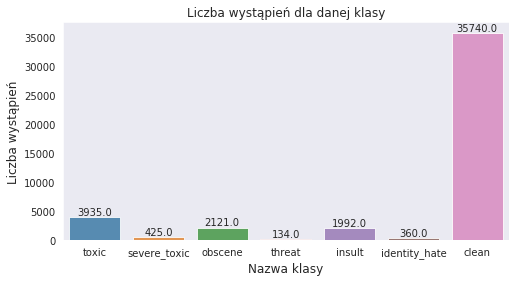

In [14]:
x=train.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Liczba wystąpień dla danej klasy")
plt.ylabel("Liczba wystąpień", fontsize=12)
plt.xlabel("Nazwa klasy", fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Klasy toksyczności mają bardzo różną liczbę elementów. Można zauważyć, że zbiór danych składa się w znacznej większości z komentarzy nietoksycznych. Ponadto klasy złośliwa, nieprzyzwoita oraz obraźliwa są znacznie bardziej liczne niż bardzo obraźliwa, groźba czy dyskryminacja.

Suma liczności wszystkich tagów jest większa niż liczność zbioru kometarzy. Część komentarzy musi więc być przypisana do więcej niż jednej klasy.

## 2.4 Współwystępowanie kategorii toksyczności


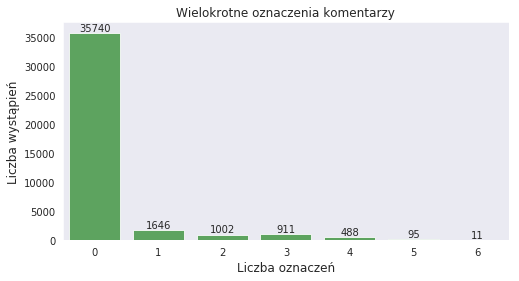

In [15]:
x=rowsums.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Wielokrotne oznaczenia komentarzy")
plt.ylabel('Liczba wystąpień', fontsize=12)
plt.xlabel('Liczba oznaczeń', fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

W korpusie znacząca część komentarzy została oznaczona jako należąca do więcej niż jednej kategorii. Tylko około 10% komentarzy zawiera w sobie. Występuje również grupa komentary, które zaklasyfikowane zostały do wszystkich kategorii jednocześnie. Model klasyfikatora będzie musiał uwzględnić możliwość współwystępowania oznaczeń dla poszczególnych komentarzy. Dalej zbadane zostaną współczynniki korelacji pomiędzy przynależnościami do kategorii.

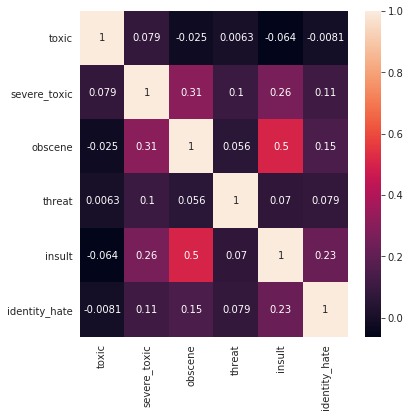

In [16]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

Powyższy wykres wskazuje na występowanie pewnej zależności pomiędzy kategoriami, jednak domyślna funkcja biblioteki Pandas obliczająca korelacje wykorzystuje współczynnik korelacji liniowej Pearsona. Współczynnik ten określa poziom zależności liniowej między zmiennymi losowymi, jednak nie może być tutaj zastosowany z uwagi na binarność zmiennych kategoryzujących.

Tak więc w celu zbadania zależności między dwoma poszczególnymi kategoriami, zdecydowano się na wykorzystanie tabeli **CrossTab** oraz **wpółczynnika V Cramera**, który jest jedną z miar zależności, określającą poziom zależności pomiędzy dwiema zmiennymi nominalnymi, spośród których co najmniej jedna przyjmuje więcej niż dwie wartości.


In [17]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize
# We will look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
# out = out.style.apply(highlight_min, axis=0)
out

severe_toxic      obscene       threat      insult        \
severe_toxic            0    1       0     1      0    1      0     1   
toxic                                                                   
0                     218    0      95   123    212    6     84   134   
1                    3510  425    1937  1998   3807  128   2077  1858   

             identity_hate       
severe_toxic             0    1  
toxic                            
0                      197   21  
1                     3596  339

Tabela zestawia tablice **CrossTab** komentarzy uznanych za obraźliwe względem innych kategorii.

Interesującą, aczkolwiek dość oczywistą obserwacją jest to, że komentarz bardzo obraźliwy jest zawsze oznaczany również jako obraźliwy. Pozostałe kategorie wydają się być podzbiorem klasy obraźliwej, z kilkoma wyjątkami.

In [18]:
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


Powyższa funkcja oblicza wpółczynnik V Cramera dla podanej w argumencie tablicy CrossTab

In [19]:
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Macierz pomyłek pomiędzy komentarzami obraźliwymi i bardzo obraźliwymi:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("Korelacja pomiędzy komentarzami obraźliwymi i bardzo obraźliwymi z wykorzystaniem współczynnika V Cramera=",new_corr)

Macierz pomyłek pomiędzy komentarzami obraźliwymi i bardzo obraźliwymi:
severe_toxic     0    1
toxic                  
0              218    0
1             3510  425
Korelacja pomiędzy komentarzami obraźliwymi i bardzo obraźliwymi z wykorzystaniem współczynnika V Cramera= 0.07613387983727797


## 2.5 Chmury znaczników dla poszczególnych kategorii


Chmury znaczników to graficzne zobrazowanie zawartości korpusu tekstowego w postaci zestawu znaczników. Najczęściej znaczniki są uszeregowane alfabetycznie, natomiast wielkość i pogrubienie fontu poszczególnych znaczników–linków jest zależne od ważności lub popularności danego znacznika. Umożliwia to łatwe znalezienie danej kategorii zarówno alfabetycznie, jak i według ważności.

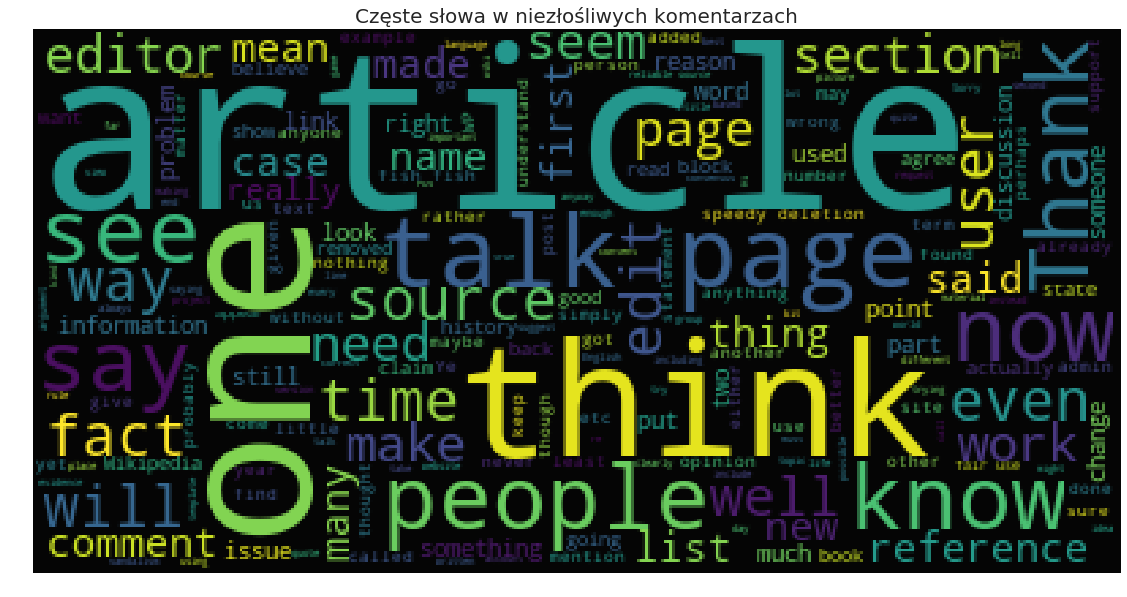

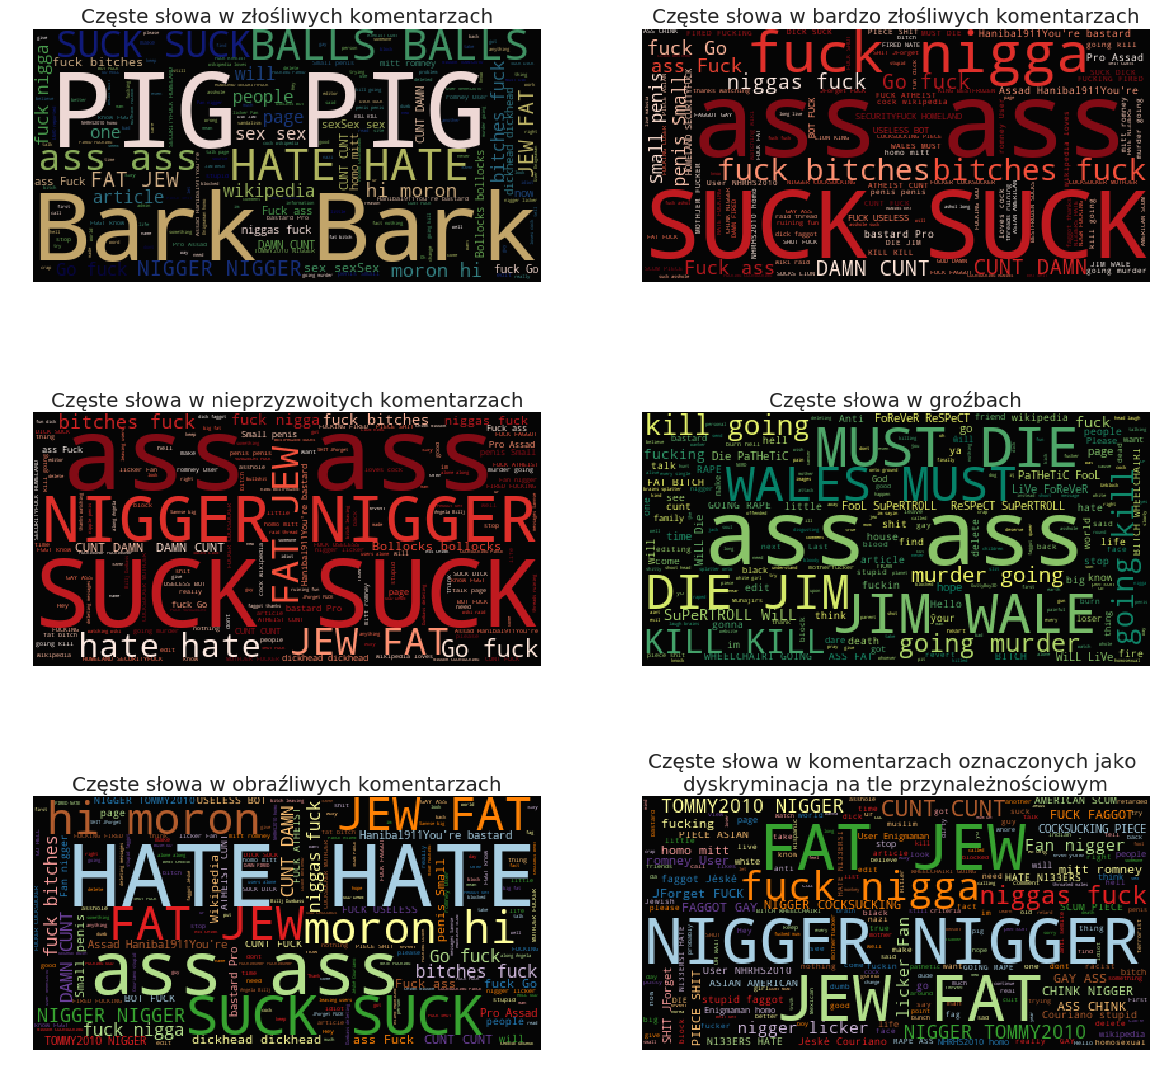

In [20]:
stopword=set(STOPWORDS)

# wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Częste słowa w niezłośliwych komentarzach", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

# wordcloud for toxic comments
plt.figure(figsize=(20,20))
plt.subplot(321)
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Częste słowa w złośliwych komentarzach", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

# wordcloud for severely toxic comments
plt.subplot(322)
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Częste słowa w bardzo złośliwych komentarzach", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

# wordcloud for obscene comments
plt.subplot(323)
subset=train[train.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Częste słowa w nieprzyzwoitych komentarzach", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

# wordcloud for threat comments
plt.subplot(324)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Częste słowa w groźbach", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

# wordcloud for insult comments
plt.subplot(325)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Częste słowa w obraźliwych komentarzach", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

# wordcloud for identity hate comments
plt.subplot(326)
subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Częste słowa w komentarzach oznaczonych jako \ndyskryminacja na tle przynależnościowym", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

## 2.6 Eksplorowanie właściwości komentarzy


W tym rozdziale przeanalizowane zostaną liczbowe właściwości poszczególnych komentarzy, takie jak:
1. liczba zdań w komentarzu
2. liczba słów w komentarzu
3. liczba unikalnych słów w komentarzu
4. liczba liter w komentarzu
5. liczba znaków interpunkcyjnych
6. liczba znaków zapisanych CapsLockiem
7. liczba znaków tytułowych
8. liczba **stopwords** występujących w komentarzu
9. średnia długość słów w komentarzu

In [21]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

Na początek połączone zostały korpusy trenujący oraz testowy w celu wspólnej analizy właściwości

In [22]:
# Sentence count in each comment:
# '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
# Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
# Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
# Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
# Punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# Upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# Title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
# Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
# Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [23]:
# features
# Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
# derived features
# Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

Powyższy wycinek kodu odpowiada za zliczenie procentowej zawartości unikalnych wystąpień słów w komentarzach oraz procentowej zawartości znaków interpunkcyjnych

In [24]:
# separate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
# join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

Korpus podzielony został ponownie na zbiory treningowy oraz testowy, a na podstawie właśności zbioru treningowego wykreślone zostały wykresy zależności

### 2.6.1 Długość komentarza a jego obraźliwość


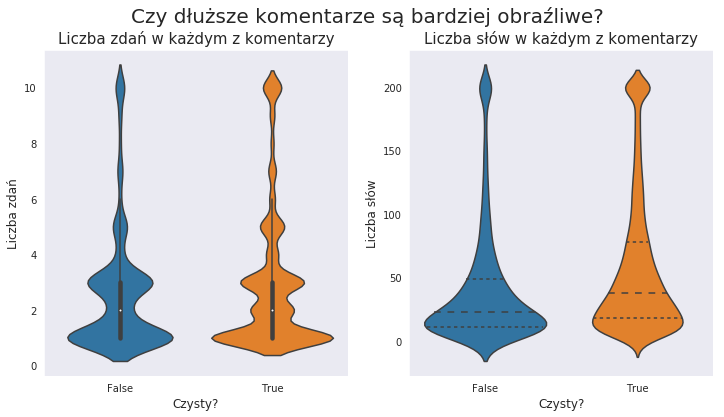

In [25]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10
plt.figure(figsize=(12,6))
# sentences
plt.subplot(121)
plt.suptitle("Czy dłuższe komentarze są bardziej obraźliwe?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Czysty?', fontsize=12)
plt.ylabel('Liczba zdań', fontsize=12)
plt.title("Liczba zdań w każdym z komentarzy", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Czysty?', fontsize=12)
plt.ylabel('Liczba słów', fontsize=12)
plt.title("Liczba słów w każdym z komentarzy", fontsize=15)

plt.show()

Z wykresów wywnioskować można, że długie komentarze z większą liczbą słów są z reguły mniej obraźliwe od tych krótszych.

Wykres wiolinowy to alternatywa do klasycznego wykresu blokowego. Wewnętrzne oznaczenia mówią o percentylu, natomiast szerokość "instrumentu" mówi o woluminie komentarzy na danym poziomie.

### 2.6.2 Unikatowość słów a obraźliwość komentarza

In [26]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
# Prepare for split violin plots
# For the desired plots, the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
# Spammers - comments with less than 30% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

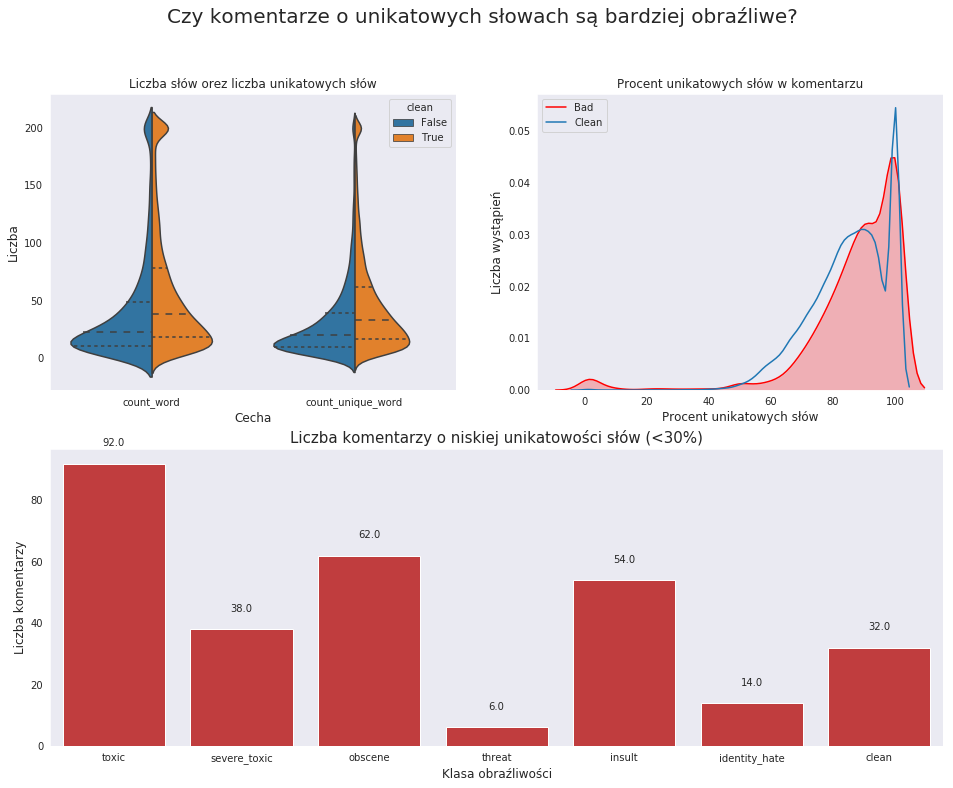

In [27]:
plt.figure(figsize=(16,12))
plt.suptitle("Czy komentarze o unikatowych słowach są bardziej obraźliwe?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df, split=True, inner='quartile')
plt.title("Liczba słów orez liczba unikatowych słów")
plt.xlabel("Cecha", fontsize=12)
plt.ylabel("Liczba", fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Procent unikatowych słów w komentarzu")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel("Liczba wystąpień", fontsize=12)
plt.xlabel("Procent unikatowych słów", fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Liczba komentarzy o niskiej unikatowości słów (<30%)",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel("Klasa obraźliwości", fontsize=12)
plt.ylabel("Liczba komentarzy", fontsize=12)
plt.show()

Pierwszy wykres to podzielony wykres wiolinowy. Ta wariacja pozwala na pionowy podział wykresu wiolinowego na podstawie kategorii danych, to znaczy na korpus komentarzy obraźliwych i czystych.
Drugi wykres przedstawia pokrycie korpusu komentarzami w przestrzeni uwzględniającej zawartość unikatowych słów dla korpusu komentarzy obraźliwych i czystych. 

Wykres pierwszy wskazuje na to, że komentarze o małej liczbie unikalnych słów są z reguły bardziej obraźliwe.
Na drugim wykresie widać wyraźne uwypuklenie w obszarze 0-10%, które reprezentuje kumulacje komentarzy obraźliwych, w których nie występuje różnorodość słów.

### 2.6.3 Wnioski z wykresów zależności właściwości komentarzy

Podsumowując analize powyższych wykresów, zauwazyć należy, że pomimo dominacji w korpusie komentarzy nieobraźliwych, niecałe 100 komentarzy uznanych za czyste są spamem. Prowadzi to do wniosków, że cecha spamu również jest znacznym wskaźnikiem obraźliwości komentarza.

# 3. Czyszczenie korpusu komentarzy

Kolejnym krokiem w budowie modelu klasyfikatora jest wyczyszczenie korpusu komentarzy. Krok ten pozwala przygotować dane do dalszego przetwarzania poprzez wykonanie operacji takich jak: ujednolicenie wielkości znaków, pozbycie się **stopwords** czy usunięcie słów charakterystycznych dla tego typu dancych tekstowych (adresy IP, nazwy użytkowników). Wszystkie użyte metody zostały opisane poniżej. 

In [28]:
corpus=merge.comment_text

Korpus inicjalizowany jest wszystkimi komentarzami, zarówno ze zbioru uczącego jak i testowego.

In [29]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

Jednym z kroków oczyszczania tekstu jest zmiana wyrażeń z apostrofami, czyli skrótów, na wyrażenia pełne. W tym celu użyty został słownik `APPO` znaleziony [tutaj](https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view).

In [30]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    # convert to lower case
    comment = comment.lower()

    # remove \n
    comment = re.sub("\\n", "", comment)
    # remove IP's
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", comment)
    # remove Wikipedia specific hyperlinks
    comment = re.sub("\[\[.*\]", "", comment)
    # remove image references
    comment = re.sub("image:([^. ]+).([^. ]+)", "", comment)
    # remove links to other talks
    comment = re.sub("redirect (.*)", "", comment)
    # remove links
    comment = re.sub("https?://.*com", "", comment)
    # remove time
    comment = re.sub("(00|[0-9]|1[0-9]|2[0-3]):(0[0-9]|[0-5][0-9])", "", comment)
    # remove date in various formats
    comment = re.sub("(january|february|march|april|may|june|july|august|september|october|november|december) ([0-3]?[0-9]),? 20[0-9][0-9] \(.*\)", "", comment)
    comment = re.sub("([0-3]?[0-9]) (january|february|march|april|may|june|july|august|september|october|november|december),? 20[0-9][0-9][ \(.*\)]?", "", comment)

    # split the sentences into words
    words = tokenizer.tokenize(comment)

    # expand apostrophe expressions into full expressions using APPO dictionary
    words = [APPO[word] if word in APPO else word for word in words]
    # lemmatize every word
    words = [lem.lemmatize(word, "v") for word in words]
    # remove stop words
    words = [w for w in words if not w in eng_stopwords]

    cleaned = " ".join(words)
    # remove any non alphanum,digit character
    cleaned = re.sub("\W+", " ", cleaned)
    # remove redundant spaces
    cleaned = re.sub("  ", " ", cleaned)

    return(cleaned)

Do czyszczenia pojedynczego komentarza służy funkcja `clean()`.
Kolejne etapy jej działania to:
- zmiana wielkich liter na małe
- usunięcie znaków nowej linii (`\n`)
- usunięcie IPv4 (np. `192.168.0.1`)
- usunięcie hiperłączy charakterystycznych dla Wikipedii (np. `[[Category:Al-Qaeda propagandists]]`)
- usunięcie odnośników do wstawianych obrazów (np. `Image:Bwbuscard_small.jpg`)
- usunięcie przekierowań do dyskusji (np. `REDIRECT Talk:Shabab Al-Khalil SC`)
- usunięcie linków (np. `https://www.google.com/`)
- usunięcie godziny (np. `12:34`)
- usunięcie dat w kilku występujących formatach (np. `6 January 2008 (UTC)`)
- rozwinięcie skrótów apostrofowych (np. `you\'re` -> `you are`)
- lematyzacja słów
- usunięcie **stopwords**
- usunięcie znaków niealfanumerycznych
- usunięcie nadmiarowych spacji

In [31]:
corpus.iloc[1675]

'"\n\nhey fuck you, who the fuck checks ""Phnom Nam Lyr Wildlife Sanctuary"" for vandalism. Get a fucking life you turd bag"'

Przykładowy komentarz przed procesem czyszczenia.

In [32]:
clean(corpus.iloc[1675])

' hey fuck fuck check phnom nam lyr wildlife sanctuary vandalism get fuck life turd bag '

Przykładowy komentarz po oczyszczeniu. Osiągnięto zamierzony efekt, tak przetworzony tekst może być użyty w dalszym krokach przetwarzania.

In [33]:
clean_corpus = corpus.apply(lambda x : clean(x))

Całkowite wyczyszczenie korpusu komentarzy.

# 4. Budowa modelu klasyfikatora

Metody uczenia maszynowego zawierają zaawansowane metody statystyczne do rozwiązywania zagadnień regresyjnych jak i klasyfikacyjnych, w których występuje wiele zmiennych wejściowych i wyjściowych. Podczas eksperymentów z budową modeli klasyfikatorów wykorzystane zostaną trzy podejścia:
1. z wykorzystaniem metod **regresji logistycznej**
2. z wykorzystaniem *Maszyn Wektorów Nośnych* wraz z *Naiwnym Klasyfikatorem Bayesa*, które dalej nazywane będzie **NB-SVM** 
3. przy zastosowaniu pakietu Keras **Long short-term memory** (LSTM), będącą architekturą sztucznej rekursywnej sieci neuronowej wykorzystywanej w zagadnieniach głębokiego uczenia.

## 4.1 Reprezentacja tekstu

Biblioteka sklearn dostarcza 3 podstawowych mechanizmów zliczania własności n-gramów. Początkowo tworzą one słownik wyrazów występujących w korpusie, a następnie konstruują macierz rzadką liczy wystąpień poszczególnych słów z utworzonego słownika. Wykorzystywane mechanizmy dotyczą:

1. CountVectorizer
    1. Tworzy macierz z częstościa występowania poszczególnych słów w korpusie
2. TF-IDF Vectorizer
    1. TF - Term Frequency -- Zlicza występowanie termów z korupsie komentarzy
    2. IDF - Inverse Document Frequency -- Egzekwuje kary za zbyt często występujące słowa.
3. HashingVectorizer
    1. Tworzy hasmapę (transformacja słów na liczby z użyciem funkcji haszującej) zamiast słownika dla słów z korpusu. Umożliwia to zwiększenie wydajności podczas pracy z dużymi korpusami.

W projekcie wykorzystane zostanie wektoryzator TF-IDF z uwagi na najlepsze wyniki osiągane tym sposobem. Wykorzystany zostanie korpus połączonych zbiorów trenującego i testującego, aby uniknąć możliwości występowania unikalnych słów ze zbioru testującego, na które model nie zareaguje.

### 4.1.1 Unigramowa reprezentacja tekstu

Na tym etapie zaimplementowana i przeanalizowana zostanie jedno-gramowa reprezentacja wyrazów korpusu z pomocą funkcjonalności zliczania częstości występowania.


In [34]:
### Unigrams -- TF-IDF 
tfv = TfidfVectorizer(min_df=200,  max_features=10000,
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

#return to the initial distribution of the corpus (train and test)
train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

Funkcja TfidfVectorizer jako parametry wektoryzacji przyjmuje:
1. *min_df* - parametr, który ustala próg częstości występowania termów, poniżej którego termy zostaną zignorowane
2. *max_features* - parametr mówiący o maksymalnej pojemności słownika
3. *analyzer* - parametr mówiący o kategorii zliczania termów - mogą to być słowa lub znaki
4. *ngram-range* - parametr mówiący o liczbie słów w gramie, w tym wypadku 1 słowo (unigram)
5. *strip_accents* - parametr-flaga, warunkujący usuwanie akcentów
6. *stop_words* - parametr ustalający korpus słów, które mają zostać pominięte
7. *use_idf, smooth_idf* - parametry uruchamiający Inverse Document Frequency

Następnie do utworzonego obiektu słownika dopasowany zostanie oczyszczony korpus komentarzy, a zliczone właśnosci zostaną przypisane do zmiennej *features*.
Dalej korpus zostanie znowu podzielony na zbiór trenujący oraz testujący.

Ze względów wydajnościowych, maksymalna wielkość słownika została ograniczona do 10000 rekordów. Najlepsze wyniki otrzymano z domyślną wartością parametru *min_df* wynoszącą 10.

In [35]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''

    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

Z repozytorium https://buhrmann.github.io/tfidf-analysis.html wykorzystane zostaną funkcje analizujące powstały słownik oraz zawarte w nim termy. Posłużą one do reprezentacji najbardziej popularnych gramów na wykresach w dalszych podrozdziałach


In [36]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

Funkcja *top_feats_by_class* gromadzi najczęściej występujące termy ze zbioru słownikowego.

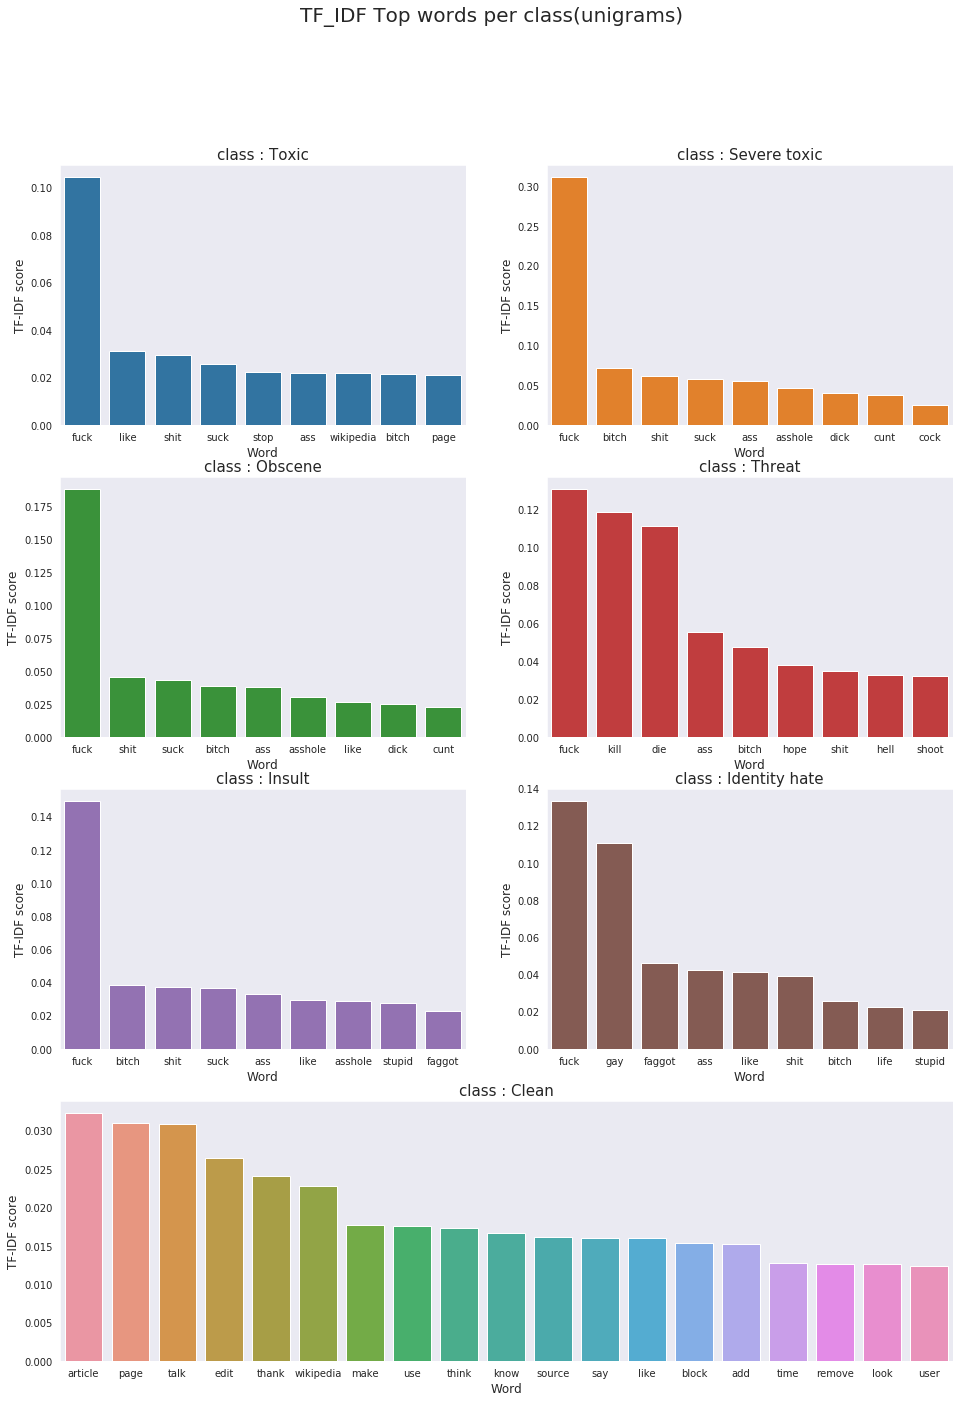

In [37]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

Wykresy pokazują najczęściej występujące termy w poszczególnych kategoriach obraźliwości. W komentarzach zaliczonych do obraźliwych widać duże zagęszczenie słów uznawanych powszechnie za obraźliwe.

### 4.1.2 Bigramowa reprezentacja tekstu

Kolejno zaimplementowana i przeanalizowana zostanie dwu-gramowa reprezentacja wyrazów korpusu z pomocą funkcjonalności zliczania częstości występowania.


In [38]:
#temp settings to min=150 to facilitate top features section to run in kernals
#change back to min=10 to get better results
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

Ponownie wykorzystana zostanie funkcja TfidfVectorizer. parametry wektoryzacji pozostaną te same, zmianie ulegnie jedynie parametr *ngram-range* ustalający liczbe słów w gramie, w tym wypadku 2 słowa (bigram). Następnie zliczone zostaną najczęściej wystęujące bigramy, które następnie zostaną wykreślone poniżej.

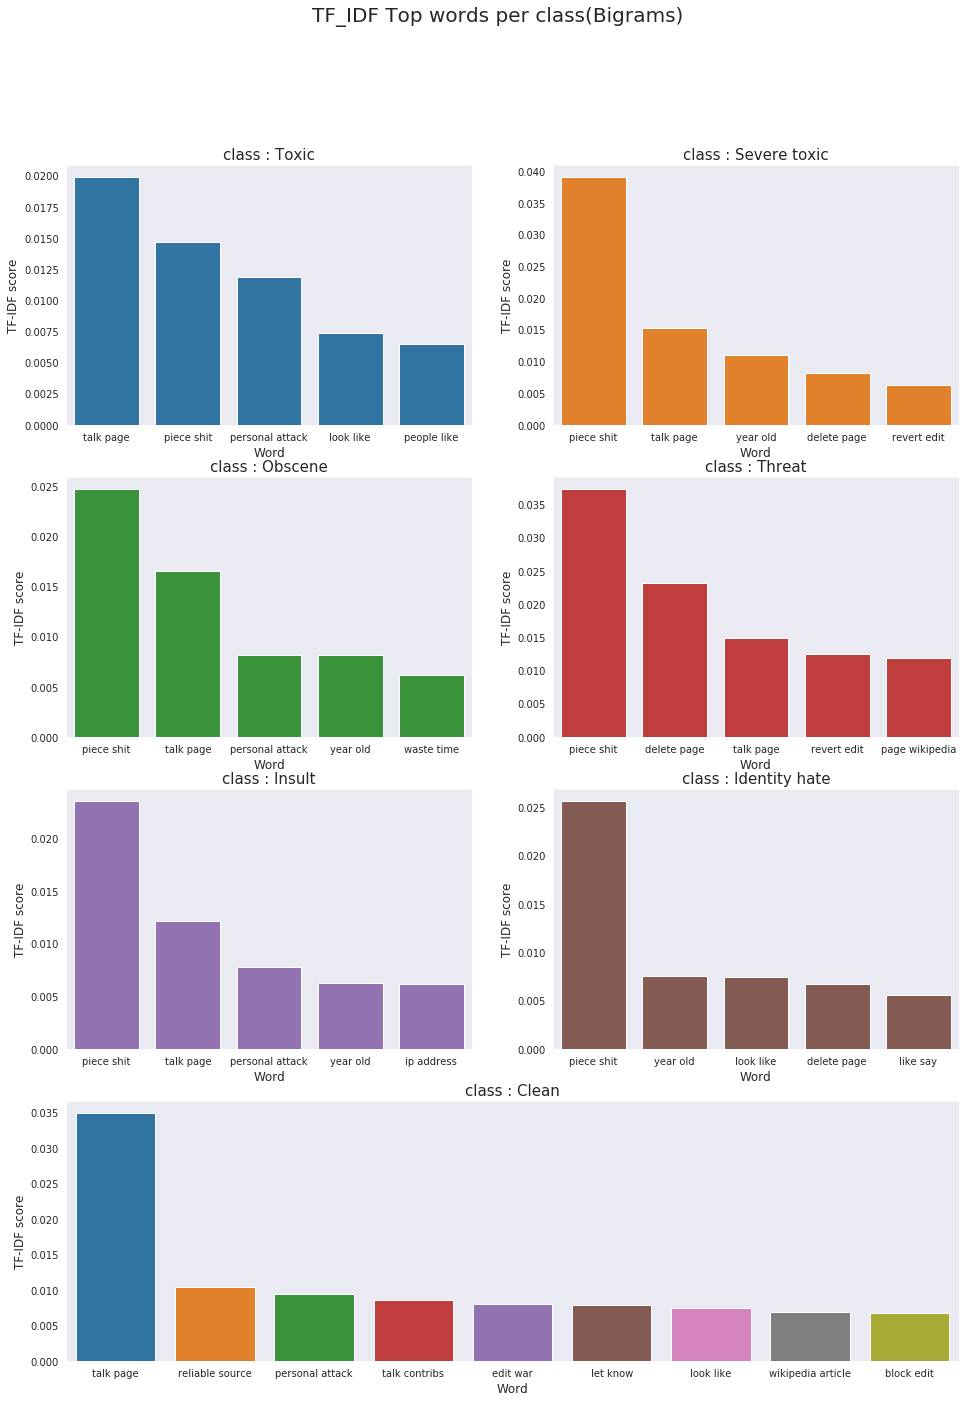

In [39]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

Wykresy pokazują najczęściej występujące bigramy w poszczególnych kategoriach obraźliwości. Znowu zauważyć można duże zagęszczenie wyrażeń wulgarnych w komentarzach skategoryzowanych jako obraźliwe.

## 4.2 Budowa modelu klasyfikatora

Ostatnim etapem projektowania klasyfikatora jest zbudowanie modelu. Wykorzystane zostaną funkcjonalności dostarczane z pakietów sklearn, które posłużą do spersonalizowanego klasyfikatora. Podjętę zostały próby stworzenia modelu na bazie:
1. Regresji logistycznej
2. Naiwnego klasyfikatora z maszyną wektorów nośnych

In [40]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]

TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train_tags[TARGET_COLS]

Przed przejściem do bezpośredniego tworzenia i nauki modelu, stworzone zostały dwa zbiory przechowujące sprawdzane własności oraz kategorie obraźliwości. Co więcej, porzucony został pomysł wykorzystania metody k-krotnej walidacji z uwagi na brak zbilansowania klasy.

### 4.2.1 Model regresji logistycznej

Regresja logistyczna to jedna z metod regresji używanych w statystyce w przypadku, gdy zmienna zależna jest na skali dychotomicznej (przyjmuje tylko dwie wartości). Zmienne niezależne w analizie regresji logistycznej mogą przyjmować charakter nominalny, porządkowy, przedziałowy lub ilorazowy. W przypadku zmiennych nominalnych oraz porządkowych następuje ich przekodowanie w liczbę zmiennych zero-jedynkowych taką samą lub o 1 mniejszą niż liczba kategorii w jej definicji.

In [43]:
model = LogisticRegression(C=3) # Smaller C values specify stronger regularization, which means modifying
                                # a learning algorithm to favor simpler prediction rules to avoid overfitting
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=1234)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

Class:= toxic
Trainloss=log loss: 0.30548736109062424
Validloss=log loss: 0.30588313641514636
Class:= severe_toxic
Trainloss=log loss: 0.05304562584536667
Validloss=log loss: 0.05289350534198129
Class:= obscene
Trainloss=log loss: 0.20022115926159278
Validloss=log loss: 0.19777772705059826
Class:= threat
Trainloss=log loss: 0.02164045452158691
Validloss=log loss: 0.02034222077401167
Class:= insult
Trainloss=log loss: 0.19223059243475302
Validloss=log loss: 0.18172479905217478
Class:= identity_hate
Trainloss=log loss: 0.046330533996170875
Validloss=log loss: 0.05693583956850935
mean column-wise log loss:Train dataset 0.1364926211916824
mean column-wise log loss:Validation dataset 0.13592620470040362


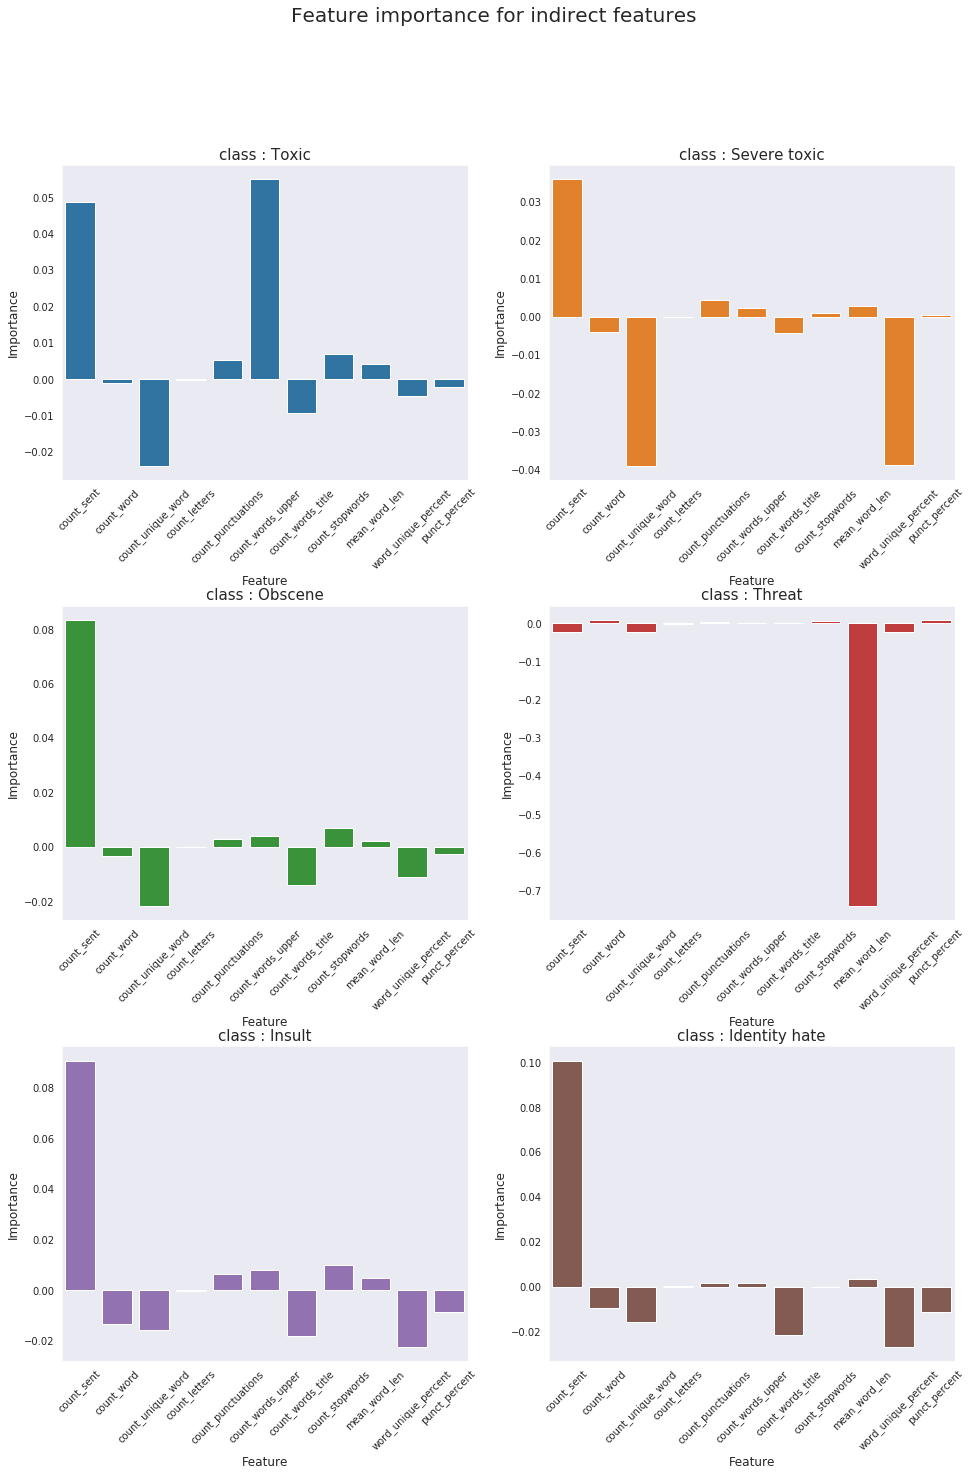

In [44]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()

Na wykresach zaobserwować można istotność poszczególnych własności komentarzy, które zostały wyznaczone przez klasyfikator. Bardzo duży wpływ na zaklasyfikowanie komentarza jako obraźliwego miała średnia długość słowa w komentarzu. Rzeczywiście, słowa powszechnie uznane za wulgarne są w języku angielskim bardzo krótkie, często nieprzekraczając 4-6 znaków. Istotna była również długość komentarzy, te krótsze klasyfikator z większym prawdopodobieństwem uznawał za obraźliwe.

Dalszej analizie poddane zostaną również wartości minimalizowanej funkcji *loss function*, wykorzystywanej w wielomianowej regresji logistycznej i jej rozszerzeniach. Funkcja ta jest zdefiniowana jako ujemny logarytm z prawdopodobieństwa przydzielenia do rzeczywistej kategorii mając za dane prawdopodobieństwo klasyfikacji modelu. Im mniejsza wartość funkcji tym, dokładniejszy klasyfikator.

Widzimy, że model z wykorzystaniem nieobudwanej funkcjonalności regresji logistycznej dość dobrze poradził sobie z problemem klasyfikacji. Komentarze bardzo obraźliwe i groźby zostały skategoryzowane z dużą dokładnością, jednak są to katgorie bardzo skrajne. O wiele gorzej poradził sobie z klasyfikacją komentarzy obraźliwych, z którymi kolejne, bardziej zaawansowane modele, poradzą sobie lepiej.

### 4.2.2 Model NB-SVM

Naiwny klasyfikator Bayesowski, bazujący na twierdzeniu Bayesa, jest szeroko stosowaną metodą, pierwotnie zaprojektowaną dla zadań klasyfikacyjnych. Prostota tej metody, wynikająca z założenia niezależności statystycznej zmiennych, powoduje, że jest ona bardzo efektywnym narzędziem klasyfikującym, łatwym w użyciu i interpretowaniu wyników. Ten prosty klasyfikator Bayesowski jest szczególnie odpowiedni przy dużej liczbie wymiarów przestrzeni zmiennych wejściowych (czyli wielu zmiennych). Z podanych wyżej powodów Naiwny klasyfikator może być często lepszy od bardziej skomplikowanych metod klasyfikacji.

Metodą maszyn wektorów nośnych wykonuje się regresję i klasyfikację, konstruując nieliniowe granice decyzyjne. Z samej natury przestrzeni cech (predyktorów), w której budowane są granice, wynika, że metoda wektorów nośnych jest bardzo elastyczna w podejściu do problemów regresji i klasyfikacji, o różnych stopniach złożoności. Istnieje kilka typów wektorów nośnych, z różnymi funkcjami bazowymi: liniową, wielomianową, RBF (radialne funkcje bazowe) i sigmoidalną.

In [45]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    
# model = NbSvmClassifier(C=float_value, dual=bool_value, n_jobs=integer_value)

Wykorzystanie powyzszych funkcji do budowy modelu **NB-SVM** odbywa się w sposób przedstawiony w ostatniej linii powyższego bloku kodu.

In [46]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1) # dual value is intepreted based on max/min problem differentation
                                                   # True value says that problem is to minimize
target_x = hstack((train_bigrams,train_unigrams,train_feats[SELECTED_COLS])).tocsr()
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

Class:= toxic
Trainloss=log loss: 0.22296431618197862
Validloss=log loss: 0.22575543993052383
Class:= severe_toxic
Trainloss=log loss: 0.0470203730619002
Validloss=log loss: 0.05516715179176833
Class:= obscene
Trainloss=log loss: 0.134721734130961
Validloss=log loss: 0.1448714199847869
Class:= threat
Trainloss=log loss: 0.010971995274461719
Validloss=log loss: 0.017086630386674375
Class:= insult
Trainloss=log loss: 0.1602027281140146
Validloss=log loss: 0.14991341165885008
Class:= identity_hate
Trainloss=log loss: 0.04200263023906297
Validloss=log loss: 0.06026215923676343
mean column-wise log loss:Train dataset 0.1029806295003965
mean column-wise log loss:Validation dataset 0.1088427021648945


Na wykresach zaobserwować można istotność poszczególnych własności komentarzy, które zostały wyznaczone przez klasyfikator. Bardzo duży wpływ na zaklasyfikowanie komentarza jako obraźliwego miała średnia długość słowa w komentarzu. Rzeczywiście, słowa powszechnie uznane za wulgarne są w języku angielskim bardzo krótkie, często nieprzekraczając 4-6 znaków. Istotna była również długość komentarzy, te krótsze klasyfikator z większym prawdopodobieństwem uznawał za obraźliwe.

Dalszej analizie poddane zostaną również wartości minimalizowanej funkcji *loss function*, wykorzystywanej w wielomianowej regresji logistycznej i jej rozszerzeniach w postaci NB-SVM. Funkcja ta jest zdefiniowana jako ujemny logarytm z prawdopodobieństwa przydzielenia do rzeczywistej kategorii mając za dane prawdopodobieństwo klasyfikacji modelu. Im mniejsza wartość funkcji tym, dokładniejszy klasyfikator.

Widzimy, że model z wykorzystaniem nieobudwanej funkcjonalności regresji logistycznej dość dobrze poradził sobie z problemem klasyfikacji. Komentarze bardzo obraźliwe i groźby zostały skategoryzowane z dużą dokładnością, jednak są to katgorie bardzo skrajne. O wiele gorzej poradził sobie z klasyfikacją komentarzy obraźliwych, z którymi kolejne, bardziej zaawansowane modele, poradzą sobie lepiej.

Model spersonalizowany NB-SVM o wiele lepiej poradził sobie z problemem klasyfikacji komentarzy na wszystkich płaszczyznach. Zmniejszyły się wartości funkcji celu obliczone dla każdej z kategorii. O wiele lepiej poradził sobie z komentarzami obraźliwymi, bardzo podobnie sklasyfikował komentarze bardzo obraźliwe i zauważalnie poprawił wyniki dla pozostałych kategorii.

W ostatnim rozdziale przetestowany zostanie model oparty na sieci neuronowej.

### 4.3 Budowa sieci neuronowej

Sieć neuronowa została zbudowana w architekturze LSTM (Long short-term memory). Jest to rozszerzenie standardowej rekurencyjnej sieci neuronowej (RNN - Recursive Neural Network). Pozwala na wnioskowanie na podstawie danych, które wystąpiły na długo przed obecnie przetwarzanymi danymi. Daje bardzo dobre rezultaty w problemach, gdzie danymi wejściowymi są dane strumieniowe, takie jak tekst.

### 4.3.1 Tokenizacja korpusu

In [47]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(clean_corpus.iloc[:train.shape[0]]))
list_tokenized_train = tokenizer.texts_to_sequences(clean_corpus.iloc[:train.shape[0]])
list_tokenized_test = tokenizer.texts_to_sequences(clean_corpus.iloc[train.shape[0]:])

Z pomocą modułu `preprocessing.text` biblioteki Keras zawierającego klasę `Tokenizer` dokonano tokenizacji korpusu. Warto zauważyć, że użyty został korpus uprzednio przygotowany (wyczyszczony). Dodatkowo przeprowadzone zostało mapowanie słów na indeksy. Poniżej wyświetlono przykładowy przetworzony komentarz.

In [48]:
list_tokenized_train[:1]

[[5,
  12,
  530,
  3612,
  8966,
  498,
  69,
  1971,
  3,
  8019,
  5003,
  1894,
  447,
  70,
  1042,
  10337,
  2101,
  15,
  21,
  3,
  40,
  296,
  6,
  2,
  91,
  7,
  30,
  2607]]

Różne komentarze mają rożną liczbę słów, natomiast dane wejściowe powinny mieć stałą liczbę cech (słów). W celu ustalenia liczby słów zastosowano **padding**. Stałą `maxlen` dobrano na podstawie poniższego histogramu. Przedstawia on ile komentarzy złożonych jest z określonej liczby słów. Da się zauważyć, że w zbiorze komentrzy nie występują takie, które miałyby ponad 200 słów. Rozmiar komentarza ustawiono więc na 200.

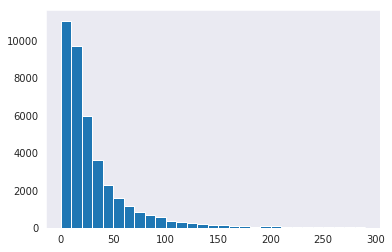

In [49]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(totalNumWords,bins = np.arange(0,300,10))
plt.show()

In [50]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
y = train[class_names].values

Zdefiniowano rozmiar danych wejściowych za pomocą maksymalnej długości komentarza użytej w procesie paddingu.

In [51]:
inp = Input(shape=(maxlen, ))

### 4.3.2 Wektorowa reprezentacja tesktu

Wektorowa reprezentacja słów została przeprowadzona przez moduł Keras za pomocą klasy Embedding. Komentarze przekształcone zostały w wektory liczb rzeczywistych, gdzie rozmiar przestrzeni wektorowej definiowany jest przez stałą `embed_size`, a liczba unikalnych słów jest równa liczbie słów unikalnych użytej w procesie tokenizacji. Parametry wektoryzacji ustalone zostały w szeregu eksperymentów, gdzie minimalizowana była funkcja straty liczona w dalszych etapach.

In [52]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

Funkcja `Embedding` zwraca tensor 3D , który przekazany jest dalej dofunkcji `LSTM`.

### 4.3.3 Budowa modelu

In [53]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

Przed przekazaniem wyniku do warstwy środkowej, należy zastosować operację przekształcenia tensora 3D w jego odpowiednik w dwóch wymiarach. Podczas tego kroku należy zwrócić szczególną uwagę na dane istotne z punktu widzenia klasyfikacji, ponieważ mogą one zostać porzucone. Nadrzędnym celem w tym krok jest, aby dane po przekształceniu dobrze reprezentowały dane oryginalne przez zastosowaniem operacji.

W celu przekształcenia wykorzystana została funkcja Global Max Pooling, która swoje zastosowanie znajduje w splotowych sieciach neuronowych, gdzie kluczowym jest zmniejszanie wymiarowości danych. Funkcja przechodzi po każdym kawałku danych i zbiera maksymalne jej wartości, które dalej staną się nowym zestawem o pomniejszonej wymiarowości. Eksperymenty pokazały, że wykorzystanie domyślnych parametrów (*Average*) dały najlepsze wyniki na etapie klasyfikacji.

In [54]:
x = GlobalMaxPool1D()(x)

Po otrzymaniu tensora 2D, zostanie on dalej przekazany do funkcji *dropout*, która podejmuje decyzje o redukcji części węzłów. W ten sposób, węzły z kolejnej warstwy są zmuszone do przechwycenia reprezentacji brakujących danych. Operacja ta znacząco poprawia ogólność i uniwersalność sieci.

Na drodze eksperymentu ustawiono wartość porzucenia na 10% węzłów.

In [55]:
x = Dropout(0.1)(x)

Po operacji porzucania węzłów, zastosowana została kolejna operacja, która ma za zadanie zwiększyć zagęszczenie połączeń między węzłami. Wykorzystuje ona funkcję RELU w celu obliczenia nowych funkcji aktywacji i wag. Zdecydowano się, że wyjściowy wymiar sieci wyniesie 50.

In [56]:
x = Dense(50, activation="relu")(x)

Ponawiamy operację porzucania 10% węzłów.


In [57]:
x = Dropout(0.1)(x)

Na końcu dane przekierowane są do warstwy o sigmoidalnej funkcji przejścia, która zwraca wartości z przedziału (0, 1). Jej zastosowanie podyktowane jest próbą osiągnięcia klasyfikacji binarnej dla każdej z 6 etykiet.

In [58]:
x = Dense(6, activation="sigmoid")(x)

Po zastosowaniu wszystkich przekształceńi operacji na sieci, należy zdefiniować wejście oraz wyjście sieci i skonfigurować odpowiednio proces nauki. W celu minimalizacji funkcji kosztu wykorzystany zostanie algorytm optymalizacji *Adam*, a sama funkcja celu zdefiniowana będzie przy pomocy funkcji z pakietu Keras *binary_crossentropy*, która wykorzystywana jest w problemach klasyfikacji binarnej.

Parametr kroku uczenia ustawiony został na domyślną wartość 0.001.

In [59]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Na koniec pozostaje etap testowania zaprojektowanej sieci neuronowej. Zbiory testujące oraz zbiory walidacyjne zostaną podzielone w stosunku 90:10. Zbiór walidacyjny zostanie następnie użyty w celu sprawdzenia, czy model sieci nie został przeuczony.

Parametem, który został dobrany na drodze eksperymentu jest wielkość jednorazowej próbki, która zostanie przepuszczona przez sieć neuronową. Jej wartość ustalono na 32.


In [60]:
batch_size = 32
epochs = 2
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 35903 samples, validate on 3990 samples
Epoch 1/2
35903/35903 [==============================] - 158s 4ms/step - loss: 0.1218 - accuracy: 0.9674 - val_loss: 0.0624 - val_accuracy: 0.9780
Epoch 2/2
35903/35903 [==============================] - 156s 4ms/step - loss: 0.0540 - accuracy: 0.9805 - val_loss: 0.0563 - val_accuracy: 0.9801


Po przetworzeniu całego ciągu uczącego dwukrotnie (dwie epoki) sieć osiąga wartości funkcji celu rzędu 0.05, co jest najlepszym wynikiem spośród przeanalizowanych modeli.

# 5. Podsumowanie i wnioski

Podsumowując, należałoby ocenić, czy tak zbudowany model posiadałby jakąkolwiek użyteczną funkcjonalność w dzisiejszych czasach i wyciągnąć kilka wniosków:

1. Dla dużych sieci i ciągów uczących składających się z wielu tysięcy wektorów uczących ilość obliczeń wykonywanych podczas całego cyklu uczenia jest gigantyczna a więc i czasochłonna. 
2. Nie zdarza się także aby sieć została dobrze zbudowana od razu. Zawsze jest ona efektem wielu prób i błędów.
3. Nigdy nie mamy gwarancji, że nawet prawidłowa sieć nie utknie w minimum lokalnym podczas gdy interesuje nas znalezienie minimum globalnego.
4. Stopień skomplikowania i pojemność modelu jest niezależna od liczby wymiarów danych dla modelu opartego na maszynie wektorów nośnych.
5. Model oparty na maszynie wektorów nośnych znajduje minimum globalne. Minimalizowana jest funkcja kwadratowa co gwarantuje znalezienie minimum. Algorytm jest bardzo wydajny i SVM generuje prawie optymalny regresor. Nie jest tez czuły na przetrenowanie.
6. Trening modelu przebiega bardzo powoli, w szczególności trening modelu, którego jądro oparte jest o funkcje wielomianową i przy dużej ilości danych użytych do treningu
7. Maszyny wektorów nośnych, choć realizujące w przeważającej liczbie przypadków zadania klasyfikacyjne, mogą z powodzeniem być wykorzystywane do budowy modelów regresorów.
8. Dane zebrane z korpusu komentarzy z serwisu Wikipedia, choć zupełne i obszerne, mogą być niereprezentatywne dla języka angielskiego, przez co zastosowanie modelu w praktyce może być utrudnione.
9. Korpus komentarzy został oznaczony arbitralnie przez użytkowników serwisu Wikipedia, więć ocena może być subiektywna i nieadekwatna.
10. Kategorie, jakimi posłużono się do opisu komentarzy były silnie powiązane ze sobą. Obraźliwość komentarza często niesie za sobą również jego nieprzyzwoitość, a groźby mogą zostać uznane po prostu za obrazę.
11. Silny wpływ na ostateczny wynik modelu miało odpowiednie oczyszczenie korpusu komentarzy